## Практический урок по бустингам

**Задача:** обучить несколько бустингов на 3-х фолдах, выбрать лучшие, усреднить предсказания.


**Исходные данные:** [quickstart_train.csv](https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv) и [quickstart_test.csv](https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv).

**Таргет:** столбец `target_reg`.

**Метрика:** `RMSE`.

**Модели, которые необходимо обучить:**
* `CatBoostRegressor`.
* `LightGBMRegressor` (goss).
* `XGBoostRegressor` (dart).


**Дополнительные условия**:

* Все модели обучаем на 3-х фолдах.
* Выбираем лучший фолд от каждой модели (получаем 3 лучших модели).
* Обязательно должна быть добавлена ячейка с сохранением 3-х лучших моделей.
* Делаем итоговое предсказание на тестовом датасете, усреднив предсказание от 3-х лучших моделей.
* Сохраняем в submission.csv только колонки `car_id` и `target_reg`.
* В конце добавляем небольшой текстовый блок с выводами.
* Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.
* Не добавляем новые признаки.
* Не используем GPU.
* Не используем Optuna.

In [62]:
!pip install catboost

In [63]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder

In [64]:
BASE_URL = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/'
RANDOM_SEED = 42

### Получение данных

In [65]:
train_data = pd.read_csv(BASE_URL + 'quickstart_train.csv')
test_data = pd.read_csv(BASE_URL + 'quickstart_test.csv')
train_data.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [66]:
# Вынесем фичи разного типа в разные списки
cat_features = ['model', 'car_type', 'fuel_type']
cols_to_drop = ['car_id']
target_cols = ['target_class', 'target_reg']

### Обучение моделей

#### CatBoost

In [67]:
# Подготовка данных
X = train_data.drop(columns=cols_to_drop + target_cols)
y = train_data['target_reg']

# Изменяем тип категориальных фичей так, что CatBoost всё устроило
for col in cat_features:
    X[col] = X[col].astype(str)

In [68]:
# Подбор гиперпараметров

model = CatBoostRegressor(
    iterations=500,
    eval_metric='RMSE',
    thread_count=-1,
    random_seed=RANDOM_SEED,
    verbose=False,
    cat_features=cat_features
)

param_distribution = {
    "colsample_bylevel": stats.uniform(),
    "depth": stats.binom(n=10, p=0.2),
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "subsample": stats.uniform(),

}

randomized_search_result = model.randomized_search(
    param_distribution,
    X,
    y,
    verbose=False,
)


bestTest = 10.81637531
bestIteration = 499


bestTest = 10.92604306
bestIteration = 499


bestTest = 12.2075523
bestIteration = 499


bestTest = 10.9144751
bestIteration = 271


bestTest = 10.76893807
bestIteration = 481


bestTest = 10.81334022
bestIteration = 175


bestTest = 10.81389273
bestIteration = 415


bestTest = 11.00076099
bestIteration = 454


bestTest = 10.76947496
bestIteration = 71


bestTest = 11.04055593
bestIteration = 68

Training on fold [0/3]

bestTest = 11.76748965
bestIteration = 483

Training on fold [1/3]

bestTest = 11.8317538
bestIteration = 499

Training on fold [2/3]

bestTest = 11.24581544
bestIteration = 443



In [69]:
# Лучшие парамеры
randomized_search_result["params"]

{'l2_leaf_reg': 5,
 'subsample': 0.8775056753965695,
 'rsm': 0.5615030923984693,
 'depth': 3.0,
 'one_hot_max_size': 3.0,
 'learning_rate': 0.03}

In [70]:
# Object importance
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
X_train = X_train.reset_index(drop=True)
train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
eval_dataset = Pool(data=X_val, label=y_val, cat_features=cat_features)

model = CatBoostRegressor(
    iterations=3000,
    eval_metric='RMSE',
    thread_count=-1,
    random_seed=RANDOM_SEED,
    **randomized_search_result["params"]
)

model.fit(
    train_dataset,
    eval_set=eval_dataset,
    early_stopping_rounds=50,
    verbose=False,
    use_best_model=True,
)

idxs, scores = model.get_object_importance(
    eval_dataset,
    train_dataset,
    importance_values_sign="Positive",
    thread_count=-1,
)

len(idxs)

1096

- model.get_feature_importance()
- model.get_object_importance()

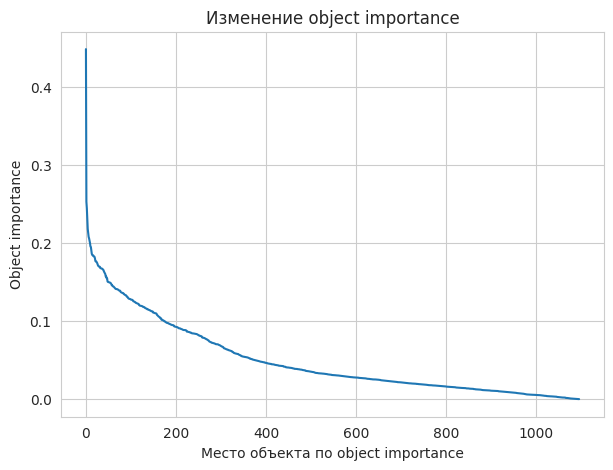

In [71]:
# Визуализируем изменение object importance
sns.set_style('whitegrid')
plt.figure(figsize=(7, 5))
sns.lineplot(scores)
plt.title('Изменение object importance')
plt.xlabel('Место объекта по object importance')
plt.ylabel('Object importance');

По графику видно, что точка перегиба находится в пределах 0.11. Отсечём все объекты, у которых object importance больше 0.11.

In [72]:
# Выбираем индексы для тех элементов, которые будут удалены
scores = np.array(scores)
idxs = np.array(idxs)
idxs_to_drop = idxs[scores > 0.11]
original_idxs = X_train.iloc[idxs_to_drop].index
print(f'Будет удалено {idxs_to_drop.shape[0]} елементов')

Будет удалено 155 елементов


In [73]:
# Удалим элементы
X_filtered = X.drop(original_idxs).reset_index(drop=True)
y_filtered = y.drop(original_idxs).reset_index(drop=True)

In [74]:
# Обучение
n_splits = 3
cat_boosts = []
cat_scores = []

kfold = KFold(n_splits, shuffle=True, random_state=RANDOM_SEED)

for train_indexes, val_indexes in kfold.split(X_filtered):
    X_train = X_filtered.loc[train_indexes]
    X_val = X_filtered.loc[val_indexes]
    y_train = y_filtered.loc[train_indexes]
    y_val = y_filtered.loc[val_indexes]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_val, label=y_val, cat_features=cat_features)

    model = CatBoostRegressor(
        iterations=3000,
        eval_metric='RMSE',
        thread_count=-1,
        random_seed=RANDOM_SEED,
        **randomized_search_result["params"]
    )

    cat_boosts.append(model)

    model.fit(
        train_dataset,
        eval_set=eval_dataset,
        early_stopping_rounds=50,
        verbose=1000,
        use_best_model=True,
    )

    cat_scores.append(model.best_score_['validation']['RMSE'])

0:	learn: 17.2275933	test: 18.0757522	best: 18.0757522 (0)	total: 835us	remaining: 2.51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.95189457
bestIteration = 434

Shrink model to first 435 iterations.
0:	learn: 17.3347113	test: 17.8041338	best: 17.8041338 (0)	total: 777us	remaining: 2.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.75845437
bestIteration = 812

Shrink model to first 813 iterations.
0:	learn: 17.8955071	test: 16.6387689	best: 16.6387689 (0)	total: 829us	remaining: 2.49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 11.32224655
bestIteration = 300

Shrink model to first 301 iterations.


In [75]:
len(cat_boosts)

3

In [76]:
# Средние метрики на кросс-валидации
assert len(cat_boosts) == n_splits
print("mean RMSE score -->", np.mean(cat_scores) - np.std(cat_scores))

mean RMSE score --> 11.414187317664318


После удаления объектов на основе object importance, средннее значение `RMSE` на кросс-валидации уменьшилось на 0.31 (11.73 --> 11.42)

In [77]:
# Выбираем и сохраняем лучший фолд
catboost_best_model = cat_boosts[np.argmin(cat_scores)]
catboost_best_model.save_model("catboost_model.cbm")

#### LightGBM

In [78]:
# Подготовка данных
X = train_data.drop(columns=cols_to_drop + target_cols)
y = train_data['target_reg']

# Изменяем тип категориальных фичей так, что LightGBM всё устроило
label_encoder = LabelEncoder()
for col in cat_features:
    X[col] = label_encoder.fit_transform(X[col])

In [79]:
# Удалим элементы на основе object importance из catboost
X_filtered = X.drop(original_idxs).reset_index(drop=True)
y_filtered = y.drop(original_idxs).reset_index(drop=True)

In [80]:
# Обучение
n_splits = 3
light_boosts = []
light_scores = []

params = {
    'boosting_type': 'goss',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'early_stopping_rounds': 50,
    'seed': RANDOM_SEED,
    'verbose': -1,
}

kfold = KFold(n_splits, shuffle=True, random_state=RANDOM_SEED)

for train_indexes, val_indexes in kfold.split(X_filtered):
    X_train = X_filtered.loc[train_indexes]
    X_val = X_filtered.loc[val_indexes]
    y_train = y_filtered.loc[train_indexes]
    y_val = y_filtered.loc[val_indexes]

    train_dataset = lgb.Dataset(
        data=X_train,
        label=y_train,
        categorical_feature=cat_features,
    )

    eval_dataset = lgb.Dataset(
        data=X_val,
        label=y_val,
        categorical_feature=cat_features,
    )

    model = lgb.train(
        params,
        train_set=train_dataset,
        valid_sets=(eval_dataset),
        num_boost_round=500,
    )

    light_boosts.append(model)

    light_scores.append(model.best_score['valid_0']['rmse'])

# Средние метрики на кросс-валидации
assert len(light_boosts) == n_splits
print("mean RMSE score -->", np.mean(light_scores) - np.std(light_scores))

mean RMSE score --> 11.73631602179455


In [81]:
# Выбираем и сохраняем лучший фолд
lgb_best_model = light_boosts[np.argmin(light_scores)]
lgb_best_model.save_model("lgb_model.mod")

#### XGBoost

In [82]:
# Подготовка данных
X = train_data.drop(columns=cols_to_drop + target_cols)
y = train_data['target_reg']

# Изменяем тип категориальных фичей так, что XGBoost всё устроило
for col in cat_features:
    X[col] = X[col].astype('category')

In [83]:
# Удалим элементы на основе object importance из catboost
X_filtered = X.drop(original_idxs).reset_index(drop=True)
y_filtered = y.drop(original_idxs).reset_index(drop=True)

In [92]:
# Добавим Scheduler для XGBoost
iters = 15
learning_rates = np.linspace(0.3, 0.005, iters).tolist()
scheduler = xgb.callback.LearningRateScheduler(learning_rates)
model = xgb.train(
        ...
        callbacks=[scheduler],
        ...
    )

In [84]:
# Обучение
n_splits = 3
xgb_boosts = []
xgb_scores = []

params = {
    'booster': 'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0,
    'nthread': -1,
    'seed': RANDOM_SEED,
}

# Добавим Scheduler
iters = 15
learning_rates = np.linspace(0.3, 0.005, iters).tolist()
scheduler = xgb.callback.LearningRateScheduler(learning_rates)

kfold = KFold(n_splits, shuffle=True, random_state=RANDOM_SEED)

for train_indexes, val_indexes in kfold.split(X_filtered):
    X_train = X_filtered.loc[train_indexes]
    X_val = X_filtered.loc[val_indexes]
    y_train = y_filtered.loc[train_indexes]
    y_val = y_filtered.loc[val_indexes]

    train_dataset = xgb.DMatrix(
        data=X_train,
        label=y_train,
        nthread=-1,
        enable_categorical=True,
    )

    eval_dataset = xgb.DMatrix(
        data=X_val,
        label=y_val,
        nthread=-1,
        enable_categorical=True,
    )

    model = xgb.train(
        params,
        dtrain=train_dataset,
        evals=[(train_dataset, 'train'), (eval_dataset, 'val')],
        num_boost_round=iters,
        callbacks=[scheduler],
        verbose_eval=0,
    )

    xgb_boosts.append(model)

    preds = model.predict(eval_dataset, iteration_range=(0, iters))
    rmse = mean_squared_error(y_val, preds, squared=False)
    xgb_scores.append(rmse)

# Средние метрики на кросс-валидации
assert len(xgb_boosts) == n_splits
print("mean RMSE score -->", np.mean(xgb_scores) - np.std(xgb_scores))

mean RMSE score --> 11.801630476274687


In [85]:
# Выбираем и сохраняем лучший фолд
xgb_best_model = xgb_boosts[np.argmin(xgb_scores)]
xgb_best_model.save_model("xgb_model.json")

### Итоговое предсказание

In [86]:
# Подготовим набор данных для сохранения
submission = test_data[['car_id']].copy()

In [87]:
# Подготовка данных
X_test = test_data.drop(columns=cols_to_drop + target_cols, errors='ignore')

# Изменяем тип категориальных фичей так, что CatBoost всё устроило
for col in cat_features:
    X_test[col] = X_test[col].astype(str)

submission['catboost_predict'] = catboost_best_model.predict(X_test)

In [88]:
# Подготовка данных
X_test = test_data.drop(columns=cols_to_drop + target_cols, errors='ignore')

# Изменяем тип категориальных фичей так, что LightGBM всё устроило
label_encoder = LabelEncoder()
for col in cat_features:
    X_test[col] = label_encoder.fit_transform(X_test[col])

submission['lgb_predict'] = lgb_best_model.predict(X_test)

In [89]:
# Подготовка данных
X_test = test_data.drop(columns=cols_to_drop + target_cols, errors='ignore')

# Изменяем тип категориальных фичей так, что XGBoost всё устроило
for col in cat_features:
    X_test[col] = X_test[col].astype('category')

test_dataset = xgb.DMatrix(
    data=X_test,
    nthread=-1,
    enable_categorical=True,
)

submission['xgb_predict'] = xgb_best_model.predict(test_dataset)

In [90]:
submission['target_reg'] = submission[
    ['catboost_predict', 'lgb_predict', 'xgb_predict']
].mean(axis=1)

submission.head()

,car_id,catboost_predict,lgb_predict,xgb_predict,target_reg
0,P17494612l,45.647347,44.333747,46.429443,45.470179
1,N-1530212S,32.523349,36.347860,34.499077,34.456762
2,B-1154399t,33.791713,34.541898,32.900021,33.744544
3,F12725233R,34.825561,35.628818,34.063446,34.839275
4,l-1139189J,33.098600,33.036712,32.295288,32.810200


In [91]:
submission[['car_id', 'target_reg']].to_csv('submission.csv', index=False)

### Выводы

* Наибольшую точность на кросс-валидации показал CatBoost, что связано с подбором гиперпараметров для него.
* Для всех трёх моделей точность увеличилась после того, как были отброшены объекты с высоким object importance.
* Scheduler дал ощутимый прирост в точности для модели XGBoost.